In [1]:
from typing import TypedDict,Annotated,Optional
from dotenv import load_dotenv
import os
from uuid import uuid4
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import add_messages, StateGraph,END

In [3]:
import json
load_dotenv()

True

In [11]:
model= ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    google_api_key=os.getenv("GEMINI_API_KEY"))
search_tool = TavilySearchResults(max_results=4)
tools=[search_tool]
memory=MemorySaver()

In [12]:
llm_with_tools=model.bind_tools(tools=tools)
llm_with_tools.invoke("Current weather At kolkata")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Current weather in Kolkata"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': []}, id='run--e39d03e3-4cad-4fae-9ffa-4c1f1571a026-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Current weather in Kolkata'}, 'id': '06762ec0-0d7f-4bc3-94e5-6ad70122a325', 'type': 'tool_call'}], usage_metadata={'input_tokens': 79, 'output_tokens': 24, 'total_tokens': 103, 'input_token_details': {'cache_read': 0}})

In [13]:
from langchain_core.messages import AIMessage,HumanMessage,ToolMessage

In [14]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [27]:
async def model(state:State):
    result=await llm_with_tools.ainvoke(state['messages'])
    return {
        'messages':[result],
    }

In [28]:
async def tools_router(state:State):
    last_message=state['messages'][-1]
    if(hasattr(last_message,"tool_calls")and len(last_message.tool_calls)>0):
        return "tool_node"
    else:
        return END

In [29]:
async def tool_node(state):
    """Custom tool node to handle tool call from llm"""
    tool_calls=state["messages"][-1].tool_calls
    tool_messages=[]
    for tool_call in tool_calls:
        tool_name=tool_call["name"]
        tool_args=tool_call["args"]
        tool_id=tool_call["id"]
        if tool_name=="tavily_search_results_json":
            search_results=await search_tool.ainvoke(tool_args)
            tool_message=ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            tool_messages.append(tool_message)
    return {"messages":tool_messages}

In [30]:
graph=StateGraph(State)
graph.add_node("model",model)
graph.add_node("tool_node",tool_node)
graph.set_entry_point("model")
graph.add_conditional_edges(
    "model",
    tools_router,
    {
        "tool_node": "tool_node",
        END: END,
    }
)

graph.add_edge("tool_node","model")
workflow=graph.compile(checkpointer=memory)


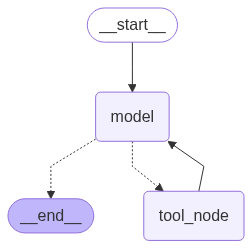

In [31]:
from IPython.display import Image,display
from langchain_core.runnables.graph import MermaidDrawMethod
display(
    Image(
        workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [35]:
config={
    "configurable":{
        "thread_id":5
    }
}
response=await workflow.ainvoke({
    "messages":[HumanMessage(content="Release date of Param Sundari movie")]
},config=config)
response

{'messages': [HumanMessage(content='How are you doing', additional_kwargs={}, response_metadata={}, id='c3f0167d-be8b-4451-ba7b-d39679bbbb6b'),
  HumanMessage(content='How are you doing', additional_kwargs={}, response_metadata={}, id='eb53ce25-787e-465f-8db1-b5b6df5546db'),
  AIMessage(content="I'm doing well, thank you for asking! I'm ready to help you with any questions or tasks you have.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': []}, id='run--6677f9ed-73f9-4cfa-a057-9267d8190c6b-0', usage_metadata={'input_tokens': 83, 'output_tokens': 26, 'total_tokens': 109, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='myself raju', additional_kwargs={}, response_metadata={}, id='8847b511-7ded-4630-847e-52de458e2a4c'),
  AIMessage(content='It is nice to meet you, Raju! I am a large language model, trained by Google. How can I help y

In [40]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

async for event in workflow.astream_events({
    "messages": [HumanMessage(content="100 word essay on spacex")],
}, config=config, version="v2"):
    # print(event)
    if event["event"]=="on_chat_model_stream":
        print(event["data"]["chunk"].content,end="",flush=True)

SpaceX, founded by Elon Musk in 2002, has revolutionized the aerospace industry with its ambitious goals and groundbreaking innovations. The company's primary objective is to reduce space transportation costs and enable the colonization of Mars. SpaceX designs, manufactures, and launches advanced rockets and spacecraft, including the Falcon 9, Falcon Heavy, and the Dragon capsule.

A key to SpaceX's success has been its development of reusable rocket technology. By landing and reusing its orbital-class rockets, SpaceX has significantly lowered the cost of space access, making space exploration more attainable. This reusability has been demonstrated consistently with the Falcon 9, which has completed numerous successful landings on both land and autonomous droneships.

SpaceX's Dragon spacecraft is another major achievement. It is the first private spacecraft capable of carrying cargo and, later, astronauts to the International Space Station (ISS). This capability has made SpaceX a cruc